In [1]:
#%pip install git+https://github.com/kmayerb/tcrdist3.git@0.2.2
from tcrdist.repertoire import TCRrep
import pwseqdist as pw
from tcrdist.rep_funcs import _pws, _pw
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')

df.head()


C:\Users\vikra\AppData\Local\Temp\ipykernel_9044\4196240058.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('vdjdb_full.txt', delimiter = '\t')


,cdr3.alpha,v.alpha,j.alpha,cdr3.beta,v.beta,d.beta,j.beta,species,mhc.a,mhc.b,...,meta.replica.id,meta.clone.id,meta.epitope.id,meta.tissue,meta.donor.MHC,meta.donor.MHC.method,meta.structure.id,cdr3fix.alpha,cdr3fix.beta,vdjdb.score
0,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02:01,HLA-A*24:02;HLA-B*08:01,HLA-B*5701...",NaN,NaN,"{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...","{""cdr3"": ""CASSYLPGQGDHYSNQPQHF"", ""cdr3_old"": ""...",2
1,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,NaN,"{""cdr3"": ""CASSFEAGQGFFSNQPQHF"", ""cdr3_old"": ""C...",2
2,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*02,HLA-A*24:02;HLA-B*08:01,HLA-B*15;HLA-...",NaN,NaN,"{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...","{""cdr3"": ""CASSFEPGQGFYSNQPQHF"", ""cdr3_old"": ""C...",2
3,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,NaN,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAVKASGSRLT"", ""cdr3_old"": ""CAVKASGSR...","{""cdr3"": ""CASSYEPGQVSHYSNQPQHF"", ""cdr3_old"": ""...",2
4,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,NaN,TRBJ2-1*01,HomoSapiens,HLA-B*08,B2M,...,NaN,NaN,NaN,PBMC,"HLA-A*01:01,HLA-A*02:01;HLA-B*08:01,HLA-B*57:0...",NaN,NaN,"{""cdr3"": ""CAYRPPGTYKYIF"", ""cdr3_old"": ""CAYRPPG...","{""cdr3"": ""CASSALASLNEQFF"", ""cdr3_old"": ""CASSAL...",2


In [3]:
df.columns

Index(['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta', 'd.beta',
       'j.beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope',
       'antigen.gene', 'antigen.species', 'reference.id',
       'method.identification', 'method.frequency', 'method.singlecell',
       'method.sequencing', 'method.verification', 'meta.study.id',
       'meta.cell.subset', 'meta.subject.cohort', 'meta.subject.id',
       'meta.replica.id', 'meta.clone.id', 'meta.epitope.id', 'meta.tissue',
       'meta.donor.MHC', 'meta.donor.MHC.method', 'meta.structure.id',
       'cdr3fix.alpha', 'cdr3fix.beta', 'vdjdb.score'],
      dtype='object')

In [4]:
# Removing rows with missing cdr3 sequences

relevant_columns = ['cdr3.alpha', 'v.alpha', 'j.alpha', 'cdr3.beta', 'v.beta',
       'j.beta', 'species', 'mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope', 'vdjdb.score'
]
df = df[relevant_columns]
df.dropna(subset=['cdr3.alpha', 'cdr3.beta'], inplace=True)
df = df[df['mhc.class']=='MHCI']
df = df[df['vdjdb.score']>0]
df = df[df['species']=='HomoSapiens']
df.drop_duplicates(inplace=True)
epitope_counts = df['antigen.epitope'].value_counts()
filtered_epitopes = (epitope_counts[epitope_counts>4]).index.to_list()
df = df[df['antigen.epitope'].isin(filtered_epitopes)]
df.reset_index(drop=True,inplace=True)
df.dropna(inplace=True)
print(len(df['antigen.epitope'].unique()))
print(df.shape)

37
(974, 12)


In [5]:
relevant_columns = ['cdr3.alpha', 'v.alpha', 'j.alpha', 'species', 'mhc.a', 'mhc.class', 'antigen.epitope', 'vdjdb.score'
]
df = df[relevant_columns]
df.shape

(974, 8)

In [6]:
df.rename(columns={'cdr3.alpha': 'cdr3_a_aa', 'cdr3.beta': 'cdr3_b_aa', 'v.alpha':'v_a_gene','j.alpha': 'j_a_gene','v.beta': 'v_b_gene','j.beta': 'j_b_gene',}, inplace=True)

In [7]:
df.head()

,cdr3_a_aa,v_a_gene,j_a_gene,species,mhc.a,mhc.class,antigen.epitope,vdjdb.score
0,CAVAGYGGSQGNLIF,TRAV12-2*01,TRAJ42*01,HomoSapiens,HLA-A*02,MHCI,ELAGIGILTV,1
1,CAVTTDSWGKLQF,TRAV12-2*01,TRAJ24*01,HomoSapiens,HLA-A*02:01:59,MHCI,LLFGYPVYV,3
2,CAAMEGAQKLVF,TRAV13-1*01,TRAJ54*01,HomoSapiens,HLA-A*02:01:48,MHCI,LLFGYPVYV,3
3,CILPLAGGTSYGKLTF,TRAV26-2*01,TRAJ52*01,HomoSapiens,HLA-B*08:01:29,MHCI,FLRGRAYGL,3
4,CAGAGSQGNLIF,TRAV27*01,TRAJ42*01,HomoSapiens,HLA-A*02:01:48,MHCI,GILGFVFTL,3


In [8]:
print(np.sum(df.isna()))

cdr3_a_aa          0
v_a_gene           0
j_a_gene           0
species            0
mhc.a              0
mhc.class          0
antigen.epitope    0
vdjdb.score        0
dtype: int64


In [9]:
# <chains> - tcrdist3 accepts ['alpha', 'beta'] or ['alpha'] or ['beta']
chains = ['alpha']
# <cdr3> We can choose either 'cdr3' or 'all'. Choosing 'all' will
# compute distances using CDR1,CDR2, and CDR2.5 as well as CDR3
cdrs = 'all'
organism = 'human'
db_file = 'alphabeta_gammadelta_db.tsv'

In [10]:
tr = TCRrep(cell_df=df,
            organism='human',
            chains=['alpha'],
            db_file='alphabeta_gammadelta_db.tsv',
            deduplicate=True)

tr.show_incomplete()

C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\vikra\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")


,cdr3_a_aa,v_a_gene,j_a_gene,species,mhc.a,mhc.class,antigen.epitope,vdjdb.score,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,cdr3_a_aa


In [11]:
X_paired = pd.DataFrame(tr.pw_alpha)
X_paired

,0,1,2,3,4,5,6,7,8,9,...,873,874,875,876,877,878,879,880,881,882
0,0,127,157,219,156,150,140,150,154,154,...,149,137,148,166,163,144,138,168,144,166
1,127,0,114,170,116,122,142,110,127,127,...,154,133,139,169,175,104,56,138,146,140
2,157,114,0,150,90,45,143,90,120,120,...,159,129,135,159,183,112,127,126,138,131
3,219,170,150,0,171,162,192,132,195,195,...,200,203,196,226,196,167,164,201,212,205
4,156,116,90,171,0,45,146,105,129,129,...,157,139,131,167,155,139,124,128,148,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,144,104,112,167,139,115,135,86,101,101,...,141,126,129,156,168,0,84,170,146,155
879,138,56,127,164,124,130,135,122,137,137,...,156,144,141,165,174,84,0,149,149,152
880,168,138,126,201,128,128,154,105,122,122,...,182,170,153,165,189,170,149,0,162,111
881,144,146,138,212,148,133,127,164,169,169,...,135,150,146,164,182,146,149,162,0,161


In [12]:
Y_paired = tr.clone_df['antigen.epitope'].copy()
Y_paired

0       EPLPQGQLTAY
1        GADGVGKSAL
2         GILGFVFTL
3         NLVPMVATV
4         NLVPMVATV
           ...     
878    DATYQRTRALVR
879       NYNYLYRLF
880       YLQPRTFLL
881       QYIKWPWYI
882       NLVPMVATV
Name: antigen.epitope, Length: 883, dtype: object

In [13]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
df_m = X_paired.copy()
df_m['epitope'] = Y_paired
#print(df_m['epitope'].value_counts())
top_9_epitopes = [
    "NLVPMVATV",
    "GILGFVFTL",
    "YLQPRTFLL",
    "QYIKWPWYI",
    "GLCTLVAML",
    "KLVALGINAV",
    "CINGVCWTV",
    "DATYQRTRALVR",
    "ELAGIGILTV"
]
        

C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\vikra\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


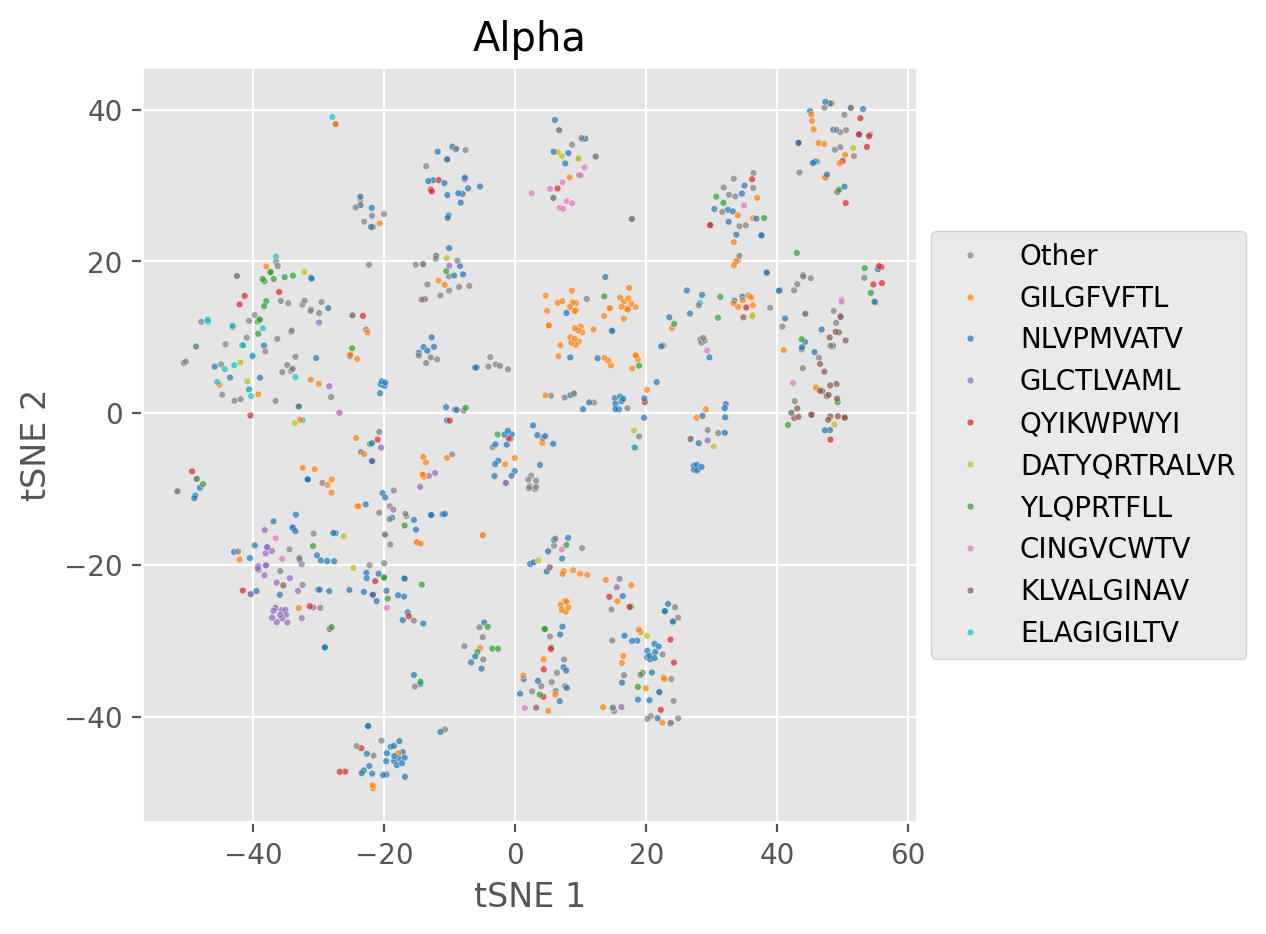

In [14]:
tsne = TSNE(n_components=2, metric='precomputed',init = 'random', random_state= 41, perplexity = 20)
tsne_result = tsne.fit_transform(X_paired)
# Determine the top 9 most common epitopes
df_m = X_paired.copy()
df_m['epitope'] = Y_paired
#df_m = df_m.sort_values('epitope')
#top_9_epitopes = df_m['epitope'].value_counts().nlargest(9).index
# Define a custom palette with unique colors for the top 9 epitopes using all colors from tab10 except the 8th
palette = sns.color_palette("tab10", len(top_9_epitopes) + 1)[:7] + sns.color_palette("tab10", len(top_9_epitopes) + 1)[8:]
# Add the 8th color for "Other" epitopes
other_color = sns.color_palette("tab10")[7]
# Create a dictionary to map top 9 epitopes to their corresponding colors
epitope_color_map = {epitope: color for epitope, color in zip(top_9_epitopes, palette)}
# Map all other epitopes to the 8th color
other_color_map = {epitope: other_color for epitope in set(df_m['epitope']) - set(top_9_epitopes)}
# Combine the color maps
combined_color_map = {**epitope_color_map, **other_color_map}
# Plot all the data and color the top 9 epitopes differently and the rest in the 8th color
plt.figure(figsize=(5, 5), dpi=200)
sns.scatterplot(data=df_m, x=tsne_result[:, 0], y=tsne_result[:, 1], s=6, alpha=0.7, hue='epitope', palette=combined_color_map, legend='full')
plt.title('Alpha')
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
# Create a custom legend
handles, labels = plt.gca().get_legend_handles_labels()
# Replace the individual epitope labels with "Other" for all other epitopes
labels = ['Other' if label not in top_9_epitopes else label for label in labels]
# Create a legend with modified labels
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label == 'Other' and label in unique_labels:
        continue
    unique_labels.append(label)
    unique_handles.append(handle)
plt.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1, 0.5))  # Adjust legend position


In [15]:
df_m['tsne_1'] = tsne_result[:,0]
df_m['tsne_2']= tsne_result[:,1]
df_m.to_csv('TcrDist_Alpha.csv', index = False)